## Здравствуйте, меня зовут *Максим Находнов*, вот моё Задание №1 по курсу ПСАД-2020!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
import scipy
from scipy.stats import linregress

def draw_linear(x, y, x_name='', y_name=''):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_lims = np.array([x.min() - 1, x.max() + 1])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

In [3]:
from sklearn.metrics import confusion_matrix

def draw_cm(x_bin, y_bin, x_name='', y_name=''):
    "Draw a confusion matrix for binary 1-D arrays x_bin and y_bin."
    cm = confusion_matrix(x_bin, y_bin)
    plt.matshow(cm)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [4]:
from itertools import combinations
from collections import defaultdict

def apply_pair_statistics(S, pair_statistics, statistics_names):
    """Apply pair statistics to each pair in a dataset S 
    and return a DataFrame containing the results.
    
    Parameters
    ----------
    S: array of shape (N, D)
        A dataset numpy array.
    pair_statistics: list of callables
        A list of statistics -- functions requiring two array arguments (x and y) 
        and returning a number (statistic's value)
    statistics_names: list of strings
        A list of statistics names.
    """
    res = defaultdict(list)

    for i, j in combinations(range(S.shape[1]), 2):
        x_name, y_name = f'X{i+1}', f'X{j+1}'
        x, y = S.T[i], S.T[j]
        res["Pair"].append(x_name + ' - ' + y_name)
        for statistic, name in zip(pair_statistics, statistics_names):
            res[name].append(statistic(x, y))

    res = pd.DataFrame(res)
    return res

## Итак...

Пусть задана обучающая выборка $\widetilde{S}$, включающая значения переменных $X_1, \dots, X_4$.

In [5]:
S = np.load('data', allow_pickle=True)
S.shape

(57, 4)

### Задача 1  

Вычислите для каждой пары переменных коэффициент корреляции Пирсона.

In [6]:
def pearson(x, y):
    "Calculate a Pearson correlation coefficient given 1-D data arrays x and y."
    x_mean, y_mean = np.mean(x), np.mean(y)
    return np.mean((x - x_mean) * (y - y_mean)) / np.std(x) / np.std(y)

res_pearson = apply_pair_statistics(S, [pearson], ['Pearson'])
res_pearson

,Pair,Pearson
0,X1 - X2,0.717535
1,X1 - X3,0.214944
2,X1 - X4,0.179368
3,X2 - X3,0.388575
4,X2 - X4,0.352562
5,X3 - X4,0.873796


Сопоставьте каждой из переменных  $X_1,\dots,X_4$  соответствующую порядковую переменную.

In [7]:
def rank(x, method='min'):
    "Assign ranks to data and return the resulting ranking array."
    def sorted_ranks_(x_, method_='min'):
        x_sorted = np.sort(x_)
        
        diff_idx = np.argwhere(x_sorted[1:] != x_sorted[:-1])
        
        min_rg = np.append(0, diff_idx + 1)
        max_rg = np.append(diff_idx, x_.shape[0] - 1)
        
        eq_len = np.append(min_rg[1:] - min_rg[:-1], x_.shape[0] - min_rg[-1])
        
        if method_ == 'min':
            return np.repeat(min_rg, eq_len)
        elif method_ == 'max':
            return np.repeat(max_rg, eq_len)
        elif method_ == 'average':
            return np.repeat(min_rg + max_rg, eq_len) / 2.0

    return sorted_ranks_(x, method_=method)[np.argsort(np.argsort(x))] + 1

S_r = np.array([rank(x, method='average') for x in S.T]).T

Вычислите для каждой из пар переменных коэффициенты корреляции Спирмена и Кендалла ($\tau$-коэффициент).

In [8]:
def spearman(x_r, y_r):
    "Calculate a Spearman correlation coefficient given 1-D ranking arrays x_r and y_r."
    return pearson(x_r, y_r)
    
def kendall(x_r, y_r):
    "Calculate a Kendall tau correlation coefficient given 1-D ranking arrays x_r and y_r."
    xless = x_r[:, None] < x_r[None, :]
    yless = y_r[:, None] < y_r[None, :]
    ygreater = y_r[:, None] > y_r[None, :]
    
    n = x_r.shape[0]

    nc = np.sum((xless * yless).astype(np.float))
    nd = np.sum((xless * ygreater).astype(np.float))
    
    n0 = n * (n - 1.0) / 2.0
    
    nx = np.unique(x_r, return_counts=True)[1]
    n1 = np.sum(nx * (nx - 1.0) / 2.0)
    
    ny = np.unique(y_r, return_counts=True)[1]
    n2 = np.sum(ny * (ny - 1.0) / 2.0)
    
    return (nc - nd) / np.sqrt((n0 - n1) * (n0 - n2))
    
    
res_ranked = apply_pair_statistics(S_r, [spearman, kendall], ['Spearman', 'Kendall'])
res_ranked

,Pair,Spearman,Kendall
0,X1 - X2,0.999789,0.996545
1,X1 - X3,0.068620,0.050911
2,X1 - X4,0.047029,0.038293
3,X2 - X3,0.070098,0.052847
4,X2 - X4,0.048231,0.041470
5,X3 - X4,0.819520,0.650535


Посмотрите на общую таблицу результатов и на графики ниже, сделайте выводы. 

При желании можно построить свои графики / вывести дополнительные результаты.

In [9]:
res_final = pd.merge(res_pearson, res_ranked)
res_final

,Pair,Pearson,Spearman,Kendall
0,X1 - X2,0.717535,0.999789,0.996545
1,X1 - X3,0.214944,0.068620,0.050911
2,X1 - X4,0.179368,0.047029,0.038293
3,X2 - X3,0.388575,0.070098,0.052847
4,X2 - X4,0.352562,0.048231,0.041470
5,X3 - X4,0.873796,0.819520,0.650535


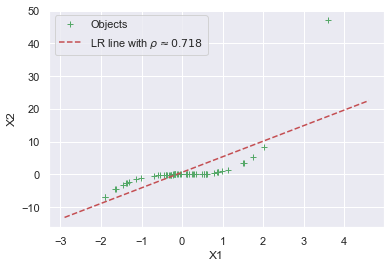

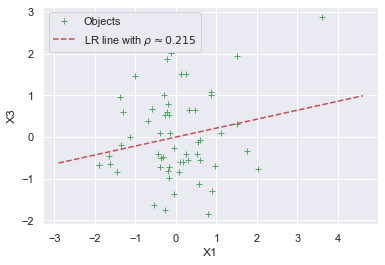

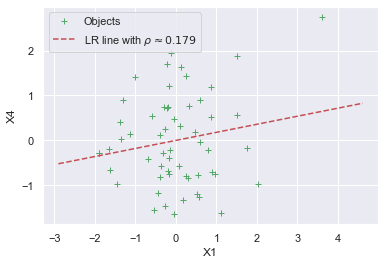

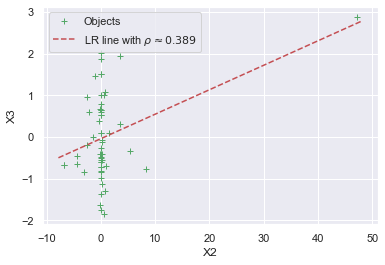

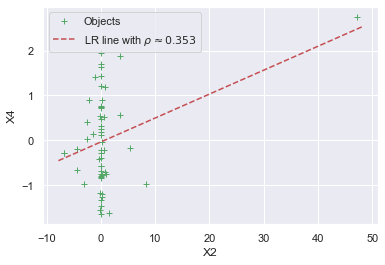

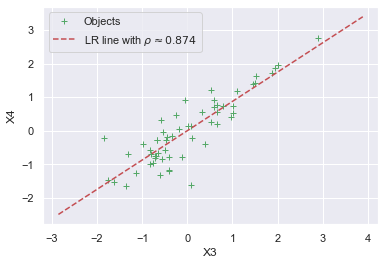

In [10]:
draw_linear(S.T[0], S.T[1], 'X1', 'X2')
draw_linear(S.T[0], S.T[2], 'X1', 'X3')
draw_linear(S.T[0], S.T[3], 'X1', 'X4')
draw_linear(S.T[1], S.T[2], 'X2', 'X3')
draw_linear(S.T[1], S.T[3], 'X2', 'X4')
draw_linear(S.T[2], S.T[3], 'X3', 'X4')

**Выводы:**
1. Заметим, что коэффициент Пирсона отражает наличие только линейной зависимости в данных, поэтому в случае пары X1 - X2 данный коэффициент значительно меньше 1. При этом, ранговые коэффициенты позволяют находить монотонные зависимости, пожтому для пары признаков X1 - X2 эти два значения близки к 1.
2. Как видно для пар X2 - X4, X2 - X3 в виду наличия выброса в данных коэффициент Пирсона принимает значение отличное от 0. При этом ранговые коэффициенты остаются устойчивыми к наличию выбросов и принимают около нулевые значения при отсутсвии зависимостей в данных
3. В случае наличия связи между переменными все коэффициенты отражают её наличие, что видно в случае пары признаков X3 - X4

### Задача 2


Бинаризуйте выборку $\widetilde{S}$ по медиане.

In [11]:
S_bin = (S > np.median(S, axis=0)).astype(np.float)

Вычислите для каждой пары бинаризованных переменных коэффициенты близости Жаккарда и $\phi$.

In [12]:
def jaccard(x_bin, y_bin):
    "Compute the Jaccard coefficient given 1-D boolean arrays x_bin and y_bin."
    return np.sum(x_bin * y_bin) / (np.sum(x_bin) + np.sum(y_bin) - np.sum(x_bin * y_bin))

def phi(x_bin, y_bin):
    "Compute the phi coefficient given 1-D boolean arrays x_bin and y_bin."
    (
        n11, n10, 
        n01, n00
    ) = (
        np.sum(x_bin * y_bin), np.sum(x_bin * (1.0 - y_bin)), 
        np.sum((1.0 - x_bin) * y_bin), np.sum((1.0 - x_bin) * (1.0 - y_bin))
    )
    
    return (n11 * n00 - n01 * n10) / np.sqrt((n11 + n10) * (n01 + n00) * (n11 + n01) * (n10 + n00))
    
res_bin = apply_pair_statistics(S_bin, [jaccard, phi], ['Jaccard', 'Phi'])
res_bin

,Pair,Jaccard,Phi
0,X1 - X2,1.000000,1.000000
1,X1 - X3,0.302326,-0.052956
2,X1 - X4,0.365854,0.087438
3,X2 - X3,0.302326,-0.052956
4,X2 - X4,0.365854,0.087438
5,X3 - X4,0.750000,0.719212


Сделайте выводы по полученным результатам и приведённым ниже матрицам ошибок.

При желании можно построить свои графики / вывести дополнительные результаты.

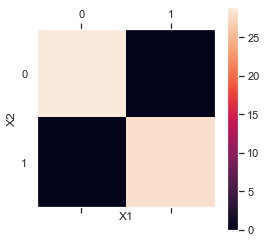

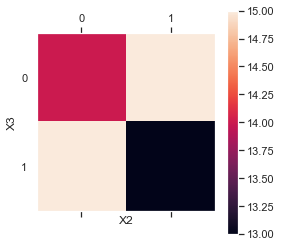

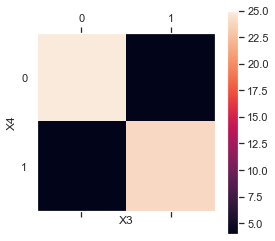

In [13]:
draw_cm(S_bin.T[0], S_bin.T[1], 'X1', 'X2')
draw_cm(S_bin.T[1], S_bin.T[2], 'X2', 'X3')
draw_cm(S_bin.T[2], S_bin.T[3], 'X3', 'X4')

**Выводы:**

1. Пара принаков X1 - X2 имеет строгую взаимосвязь следущего рода: оба значения или одновременно больше своей медианы, или одновременно меньше медианы. Оба коэффициента позволили обнаружить эту взаимосвязь. Её наличие хорошо отображается на Color Map, т.к. видно, что сумма внедиагональных элементов близка к 0.
2. В случае признаков X3 - X4 взаимосвязь такого же вида присутствует, однако для некоторых объектов есть исключения. Это отображают или отличные от 1 значения коэффициентов и не нулевая сумма внедиагональных элементов Color Map.
3. Рассматривая Color Map для X2 - X3 видно, что эта матрица значительно не диагональна. Что свидетельствует о том, что между признаками отсутствует взаимосвязь, описанная выше. Близкие к нули значения коэффициентов подтверждают это.

### Задача 3

#### Продолжительность жизни крыс

В исследовании принимало участие 195 крыс. 106 из них держали на строгой диете, оставшиеся 89 — на диете ad libitum. Имеющиеся данные: продолжительность жизни крыс в каждой из групп. Влияет ли диета на продолжительность жизни?

In [14]:
rats = pd.read_table("rats.txt", sep="\t")
rats.sample(5)

,lifespan,diet
86,1206,restricted
100,1316,restricted
171,753,ad libitum
9,403,restricted
174,768,ad libitum


In [15]:
x1 = rats.loc[rats['diet'] == 'restricted']['lifespan']
x2 = rats.loc[rats['diet'] == 'ad libitum']['lifespan']

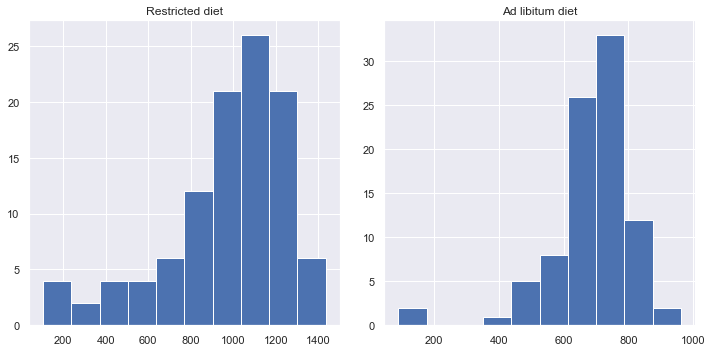

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Restricted diet')
plt.hist(x1)
plt.subplot(1, 2, 2)
plt.title('Ad libitum diet')
plt.hist(x2)
plt.tight_layout()

1. Нарисуйте один график с двумя boxplot на нем (для каждой из диет). Укажите на графике 95% доверительный интервал для каждой из медиан. В этом вам поможет функция boxplot(..., notch=TRUE), которой первым аргументом можно передать объект типа формула.

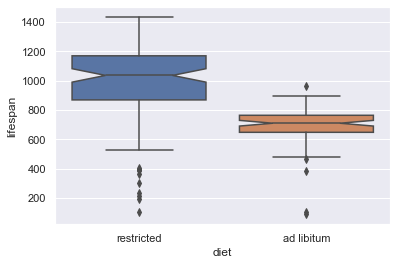

In [17]:
sns.boxplot(x='diet', y='lifespan', data=rats, notch=True)

### Нормальность

2. Проверим нормальность двух выборок (для каждой из диет). Для этого нарисуйте qq-график и отметьте на нем прямую линию, соответствующую идеальным теоретическим квантилям нормального распределения. Похожи ли данные на нормальное распределение?

In [18]:
def qqplot(data, labels):
    fig, axes = plt.subplots(1, len(data), figsize=[9 * len(data), 7])
    if len(data) == 1:
        axes = [axes]
    quantiles = np.linspace(1e-5, 1.0 - 1e-5, 101)
    normal_q = scipy.stats.norm.ppf(quantiles)
    
    for idx, data_chunk in enumerate(data):
        x_std = (data_chunk - np.mean(data_chunk)) / np.std(data_chunk, ddof=1)
        x_std_q = np.quantile(x_std, quantiles)
        
        axes[idx].plot(normal_q, x_std_q, ls='', marker='o', markersize=3, label=labels[idx])
        axes[idx].set_xlabel('Normal quantiles')
        axes[idx].set_ylabel('Sample quantiles')
        axes[idx].legend()
        axes[idx].grid(True)
        
        minq = min(np.min(x_std_q), np.min(normal_q))
        maxq = max(np.max(x_std_q), np.max(normal_q))

        axes[idx].plot([minq, maxq], [minq, maxq], '--', linewidth=2)

Посмотрим, как выглядит QQ-график для семплов из нормального распределения. Тем самым мы сможем оценить, как сильно полученные результаты могут отличаться от теоретических, т.е. оценить погрешность связнную с конечным размером выборки

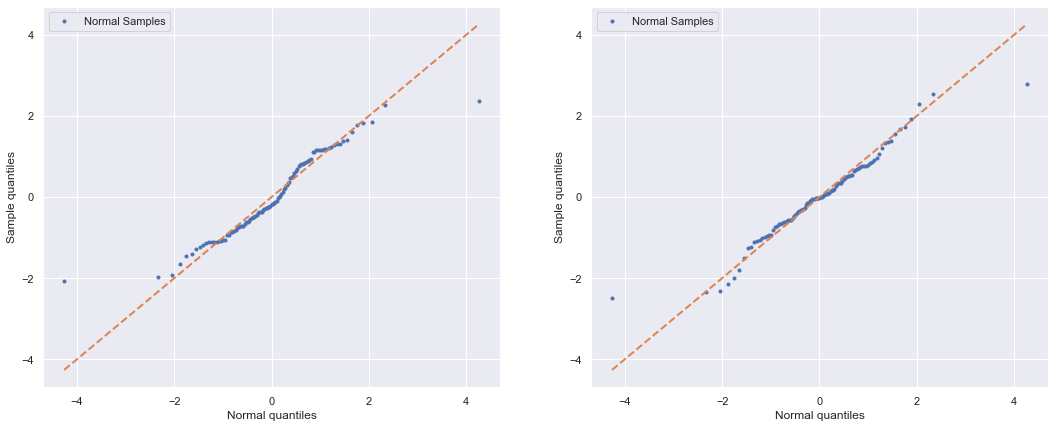

In [19]:
qqplot(
    [np.random.normal(0.0, 1.0, x1.shape[0]), np.random.normal(0.0, 1.0, x2.shape[0])],
    ['Normal Samples', 'Normal Samples']
)

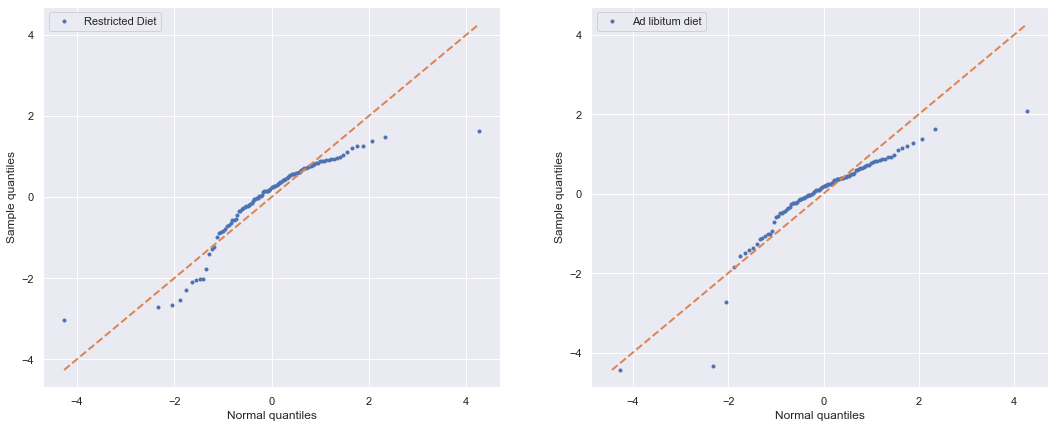

In [20]:
qqplot([x1, x2], ['Restricted Diet', 'Ad libitum diet'])

Видно, что для исходных данных кривая на графике значительно отличается от прямой, что говорит о том, что выборка не является нормально распределённой.

3. Попробуйте исключить крыс, проживших меньше 400 дней (например, можно предположить, что смерть раньше этого срока вызывается причинами, не связанными с диетой) и снова нарисовать qq-графики. Можно ли применять к этим данным критерии, основанные на предположении о нормальности?

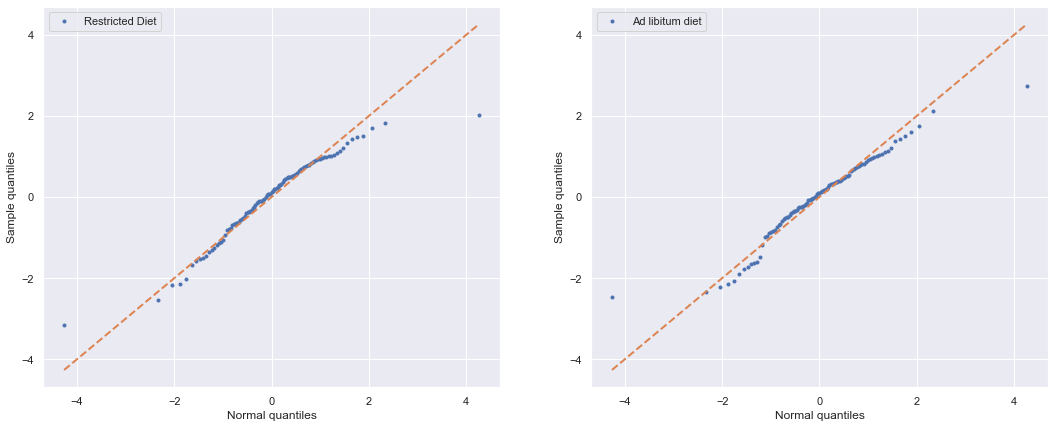

In [21]:
qqplot([x1[x1 >= 400], x2[x2 >= 400]], ['Restricted Diet', 'Ad libitum diet'])

Несмотря на отличия от прямой, полученная кравая схожа с видом кривой на QQ-графике для выборки их нормального распределения, что говорит о том, что данные можно считать нормально распределёнными.

### Сравнение средних

Проверьте нулевую гипотезу

$H_0$: продолжительность жизни крыс не меняется при ограничении диеты.

против следующих альтернатив:

$H_1$: крысы на строгой диете живут дольше.

$H_1$: средняя продолжительность жизни крыс меняется при ограничении диеты. 

Проверить правильность вычислений вы можете с помощью библиотечной функции `scipy.stats.ttest_ind`, которая реализует двусторонний критерий Стьюдента для двух независимых выборок.

In [22]:
x1_truncated = x1[x1 >= 400]
x2_truncated = x2[x2 >= 400]

n1, n2 = x1_truncated.shape[0], x2_truncated.shape[0]
x1_mean, x2_mean = np.mean(x1_truncated), np.mean(x2_truncated)
S1_2, S2_2 = np.var(x1_truncated, ddof=1), np.var(x2_truncated, ddof=1)

T = (x1_mean - x2_mean) / np.sqrt(S1_2 / n1 + S2_2 / n2)
nu = (S1_2 / n1 + S2_2 / n2) ** 2 / (S1_2 ** 2 / n1 ** 2 / (n1 - 1) + S2_2 ** 2 / n2 ** 2 / (n2 - 1))

p_value = 2.0 * scipy.stats.t.sf(np.abs(T), df=nu) 

print(T, nu, p_value)

14.527701019046814 141.33154919379606 7.882364548202493e-30


Положим уровень значимости $\alpha = 0.05$. Учитывая симметричность распределения Стьюдента, значение $p_{value} < \frac{\alpha}{2} < \alpha$, следовательно нулевая гипотеза должна быть отвергнута и против двусторонней гипотезы $H_1$ и против односторонней гипотезы $H_1$. Как следствие, средняя продолжительность жизни крыс меняется при ограничении диеты, и более того, крысы на строгой диете живут дольше.